# to Hive DB

In [7]:
!pip install seaborn==0.11

  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 286kB 1.4MB/s 
  Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1


In [ ]:
!conda install -c conda-forge imbalanced-learn

In [ ]:
import pandas as pd
from imblearn.datasets import make_imbalance
from sklearn.datasets import make_classification, make_circles, make_moons, make_blobs
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
ir = 100
n_samples = 10000

def to_hive_safely(df, table):
    df=df.withColumn("idn", F.col("idn").cast("int"))
    df=df.withColumn("label", F.col("label").cast("int"))
    assembler = VectorAssembler(
        inputCols=["feature_1", "feature_2"],
        outputCol="features_no_scale")
    df = assembler.transform(df)
    scaler = StandardScaler(inputCol="features_no_scale", outputCol="features",
                        withStd=True, withMean=True)
    scalerModel = scaler.fit(df)
    scaledData = scalerModel.transform(df)
    scaledData.write.mode("overwrite").saveAsTable(table)


In [ ]:
X,y= make_classification(n_samples = n_samples*10, n_features=2, n_informative= 1, n_redundant=0, n_clusters_per_class= 1,  random_state=10,  class_sep=0.5)
X, y = make_imbalance(X, y,sampling_strategy={0: int(n_samples/(ir+1)), 1: int((ir)*(n_samples/(ir+1)))},
                              random_state=42)
data_ir_100 = pd.DataFrame(X, columns = ['feature_1', 'feature_2'])
data_ir_100['label'] = y
data_ir_100.reset_index(inplace=True)
data_ir_100.rename(columns={'index': 'idn'}, inplace=True)
df=spark.createDataFrame(data_ir_100)
to_hive_safely(df, "dummy_data_v1")

In [ ]:
X,y= make_circles(n_samples = n_samples*10,noise=0.05, random_state=42,shuffle=True)
X, y = make_imbalance(X, y,sampling_strategy={0: int(n_samples/(ir+1)), 1: int((ir)*(n_samples/(ir+1)))},
                              random_state=42)
data_ir_100 = pd.DataFrame(X, columns = ['feature_1', 'feature_2'])
data_ir_100['label'] = y
data_ir_100.reset_index(inplace=True)
data_ir_100.rename(columns={'index': 'idn'}, inplace = True)
df=spark.createDataFrame(data_ir_100)
to_hive_safely(df, "dummy_data_v2")

In [ ]:
X,y= make_moons(n_samples = n_samples*10,noise=0.2, random_state=42, shuffle=True)
X, y = make_imbalance(X, y,sampling_strategy={0: int(n_samples/(ir+1)), 1: int((ir)*(n_samples/(ir+1)))},
                              random_state=42)
data_ir_100 = pd.DataFrame(X, columns = ['feature_1', 'feature_2'])
data_ir_100['label'] = y
data_ir_100.reset_index(inplace=True)
data_ir_100.rename(columns={'index': 'idn'}, inplace = True)
df=spark.createDataFrame(data_ir_100)
to_hive_safely(df, "dummy_data_v3")

In [ ]:
X,y= make_blobs(n_samples = n_samples*10, random_state=42, shuffle=True, centers=2, cluster_std=3)
X, y = make_imbalance(X, y,sampling_strategy={0: int(n_samples/(ir+1)), 1: int((ir)*(n_samples/(ir+1)))},
                              random_state=42)
data_ir_100 = pd.DataFrame(X, columns = ['feature_1', 'feature_2'])
data_ir_100['label'] = y
data_ir_100.reset_index(inplace=True)
data_ir_100.rename(columns={'index': 'idn'}, inplace = True)
df=spark.createDataFrame(data_ir_100)
to_hive_safely(df, "dummy_data_v4")

# Make comparing plots

In [1]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_context("paper")

In [2]:
path = pathlib.Path("data/datasetExample") 
results = pd.DataFrame()
ds = []
methods = []
datasets_df = []

for i in path.glob('**/*.csv'):
    partial = pd.read_csv(i.absolute(), header=None)
    partial.columns = ['idn', 'feature_1', 'feature_2', 'label', 'is_selected']
    paths = i.parts[2].split("_")
    datasetid = "_".join(paths[0:3])
    partial['dataset_id'] = datasetid

    if datasetid not in ds:
        print("first datasets")
        datasets_df.append(partial.drop("is_selected", axis = 1))

    partial['ands'] = int(paths[4])
    partial['lsh'] = paths[3]
    if paths[5]=='drop3':
        #method = f"LSH: {paths[3]} with {paths[4]} ANDS, IS: {'_'.join(paths[5:])}"
        partial['is'] = '_'.join(paths[5:])
        method = f"{paths[3]}"
        partial['is_ands'] = f"{'_'.join(paths[5:])}-{paths[4]} ANDS"
    else:
        #method = f"LSH: {paths[3]} with {paths[4]} ANDS, IS: {paths[5]}"
        partial['is'] = paths[5]
        method = f"{paths[3]}"
        partial['is_ands'] = f"{paths[5]}-{paths[4]} ANDS"
    #print(i.absolute(), datasetid, method)
    partial['LSH'] = method
    to_append = [results]       
    to_append.append(partial[partial.is_selected==1].copy().drop("is_selected", axis = 1))
    results = pd.concat(to_append, ignore_index = True)
    ds.append(datasetid)
    methods.append(method)
ds = list(set(ds))
methods = list(set(methods))
total_plots = len(ds)*len(methods)
results= results[results.ands.isin([2,10])].copy().reset_index(drop = True)
datasets_df = pd.concat(datasets_df)

first datasets
first datasets
first datasets
first datasets


In [3]:
#order = results[results.dataset_id==ds[0]].sort_values(by = ['lsh', 'is', 'ands'], ascending  = [True, False, True]).method.unique()
col_order = ["entropy-2 ANDS", "entropy-10 ANDS", 
            "drop3_one-2 ANDS", "drop3_one-10 ANDS",
            "drop3_boundaries-2 ANDS", "drop3_boundaries-10 ANDS"]
row_order = ['hyperplanes', 'projection','hyperplanes-projection']
face_color = {"entropy-2 ANDS": "1.0", "entropy-10 ANDS": "1.0",
              "drop3_one-2 ANDS": ".9", "drop3_one-10 ANDS":".9",
              "drop3_boundaries-2 ANDS": ".85", "drop3_boundaries-10 ANDS": ".85"}

In [39]:
def plot_example(ds_p):
    g = sns.FacetGrid(data = results[results.dataset_id==ds_p],
                  hue = 'label', row = 'LSH', col='is_ands',
                  col_order =col_order, row_order = row_order,
                  margin_titles = True, despine=True, aspect=1.5)
    g.map_dataframe(sns.scatterplot,
                x='feature_1', 
                y='feature_2', 
                alpha = 0.8)
    for (col_val, row_val), ax in g.axes_dict.items():
        #print(col_val, row_val)
        ax.set_title(row_val, fontdict = {"fontsize": "xx-large"})
        ax.set_facecolor(face_color[row_val])
        mar_title = [c for c in ax.get_children() if type(c) == matplotlib.text.Annotation]
        mar_title = [c for c in mar_title if "LSH" in c.get_text()]
        if len(mar_title)>0:
            mar_title = mar_title[0] 
            mar_title.set_fontsize("x-large")
            print(mar_title)
    
        sns.scatterplot(data= datasets_df[datasets_df['dataset_id']==ds_p], 
        x = 'feature_1', y = 'feature_2', hue = 'label' , palette = 'gist_gray', alpha=0.05, ax = ax, legend = False)
    plt.tight_layout()
    plt.savefig(f'report/{ds_p}.png', dpi = 300)
    print(ds_p, "saved")

Annotation(1.02, 0.5, 'LSH = hyperplanes')
Annotation(1.02, 0.5, 'LSH = projection')
Annotation(1.02, 0.5, 'LSH = hyperplanes-projection')
dummy_data_v1 saved


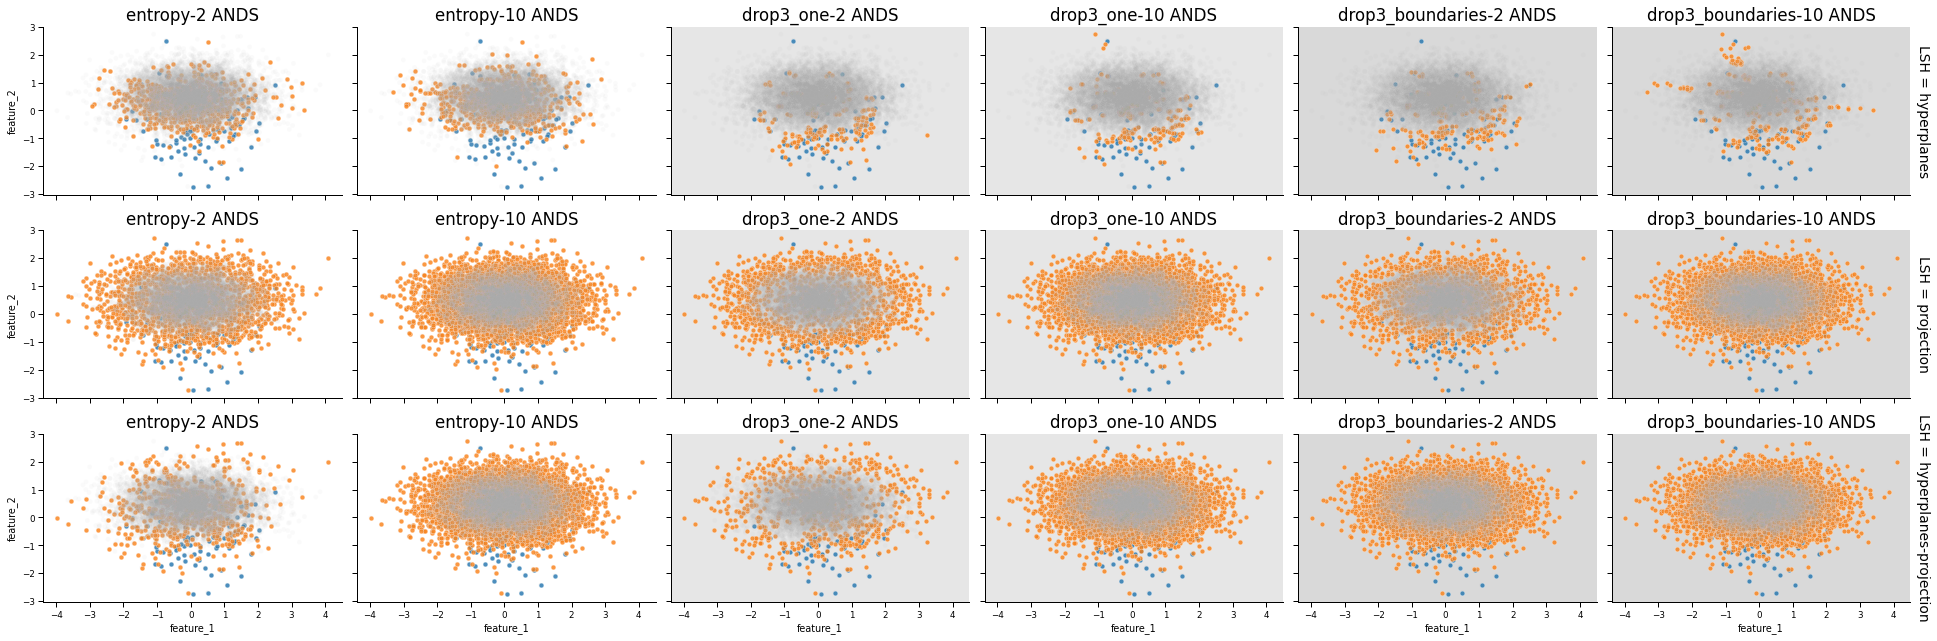

In [40]:
plot_example(ds[0])

Annotation(1.02, 0.5, 'LSH = hyperplanes')
Annotation(1.02, 0.5, 'LSH = projection')
Annotation(1.02, 0.5, 'LSH = hyperplanes-projection')
dummy_data_v2 saved


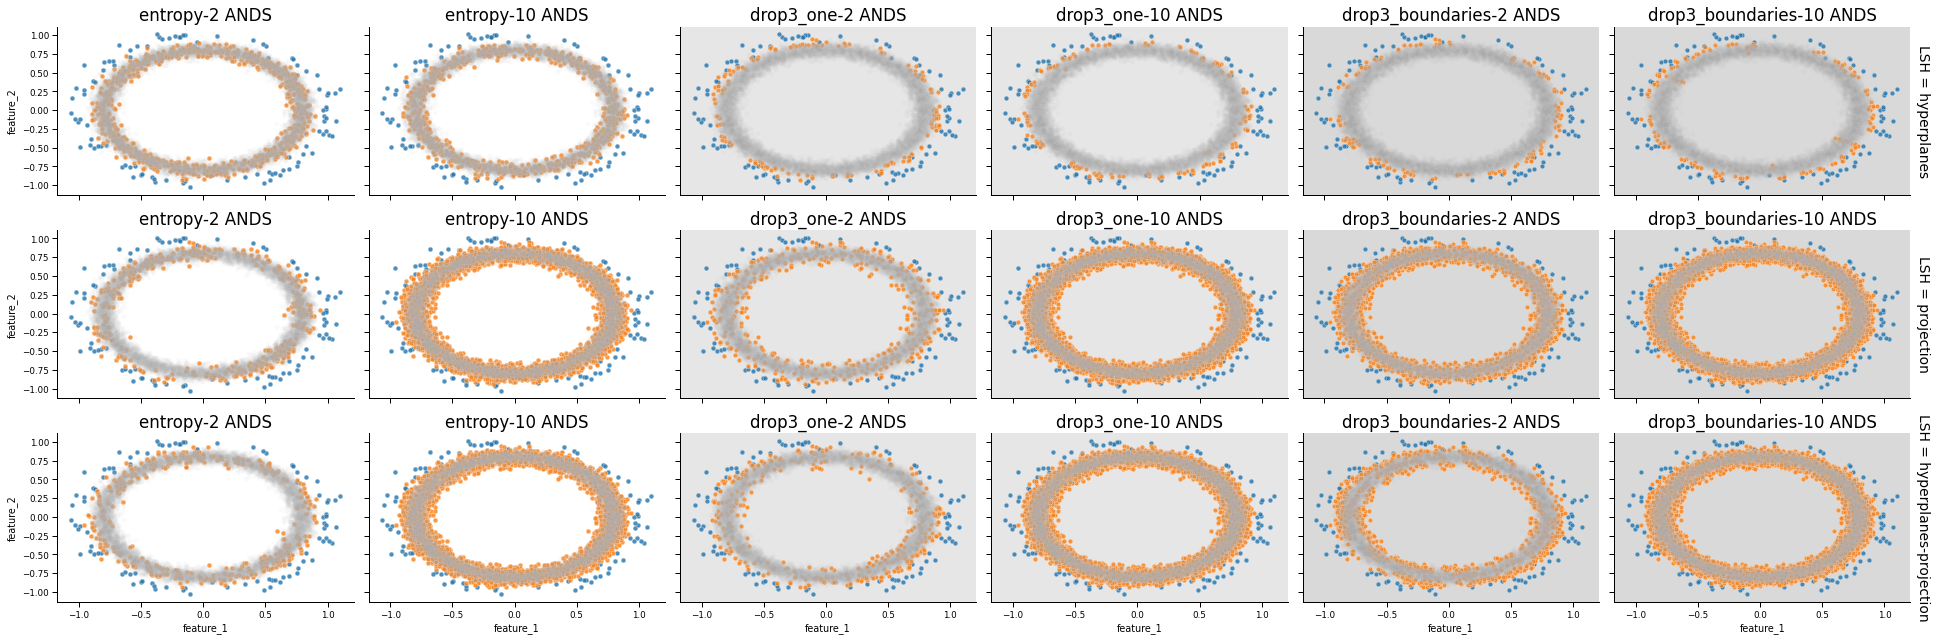

In [41]:
plot_example(ds[1])

Annotation(1.02, 0.5, 'LSH = hyperplanes')
Annotation(1.02, 0.5, 'LSH = projection')
Annotation(1.02, 0.5, 'LSH = hyperplanes-projection')
dummy_data_v3 saved


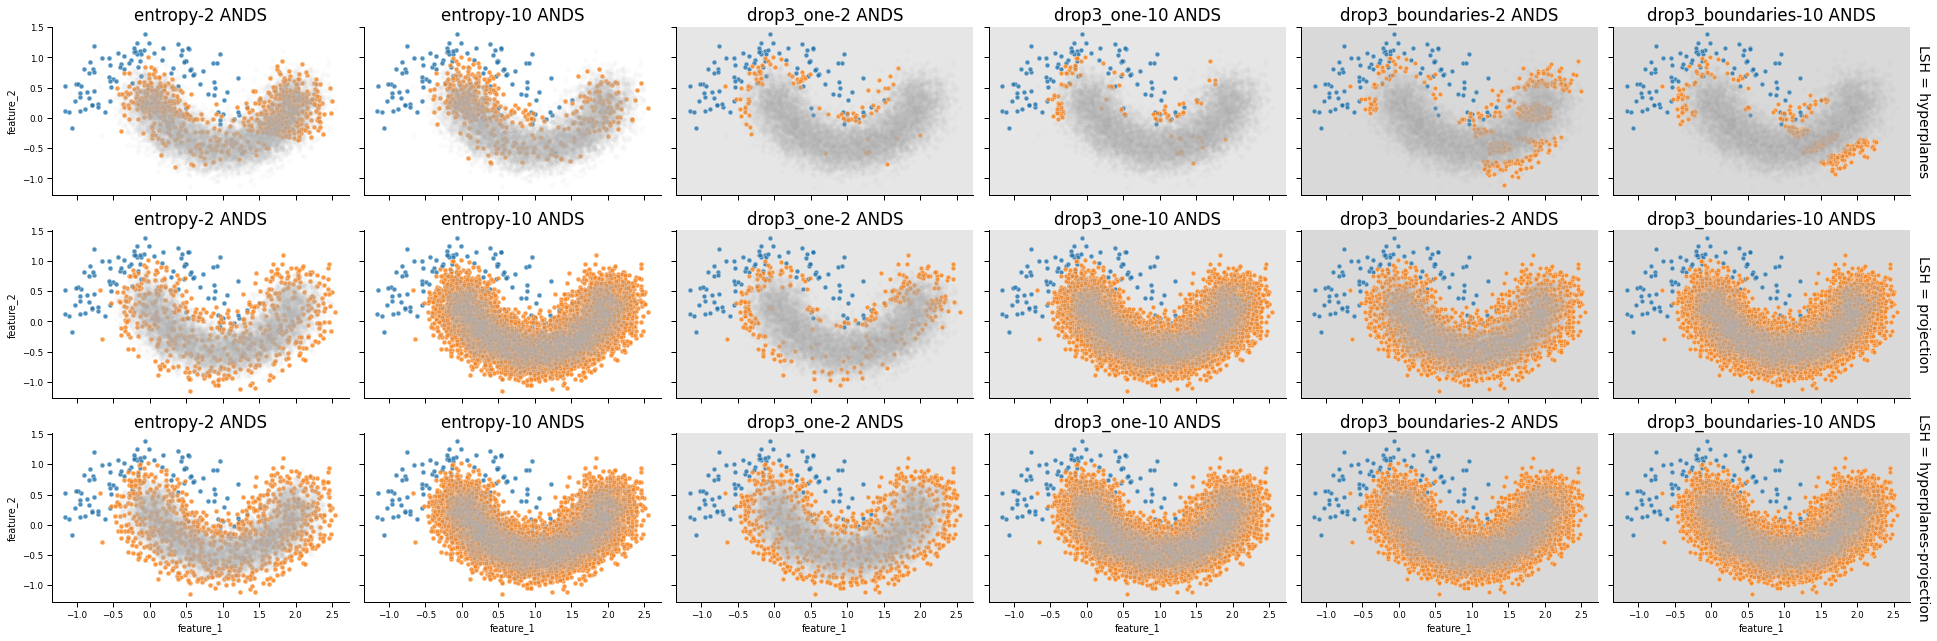

In [42]:
plot_example(ds[2])

Annotation(1.02, 0.5, 'LSH = hyperplanes')
Annotation(1.02, 0.5, 'LSH = projection')
Annotation(1.02, 0.5, 'LSH = hyperplanes-projection')
dummy_data_v4 saved


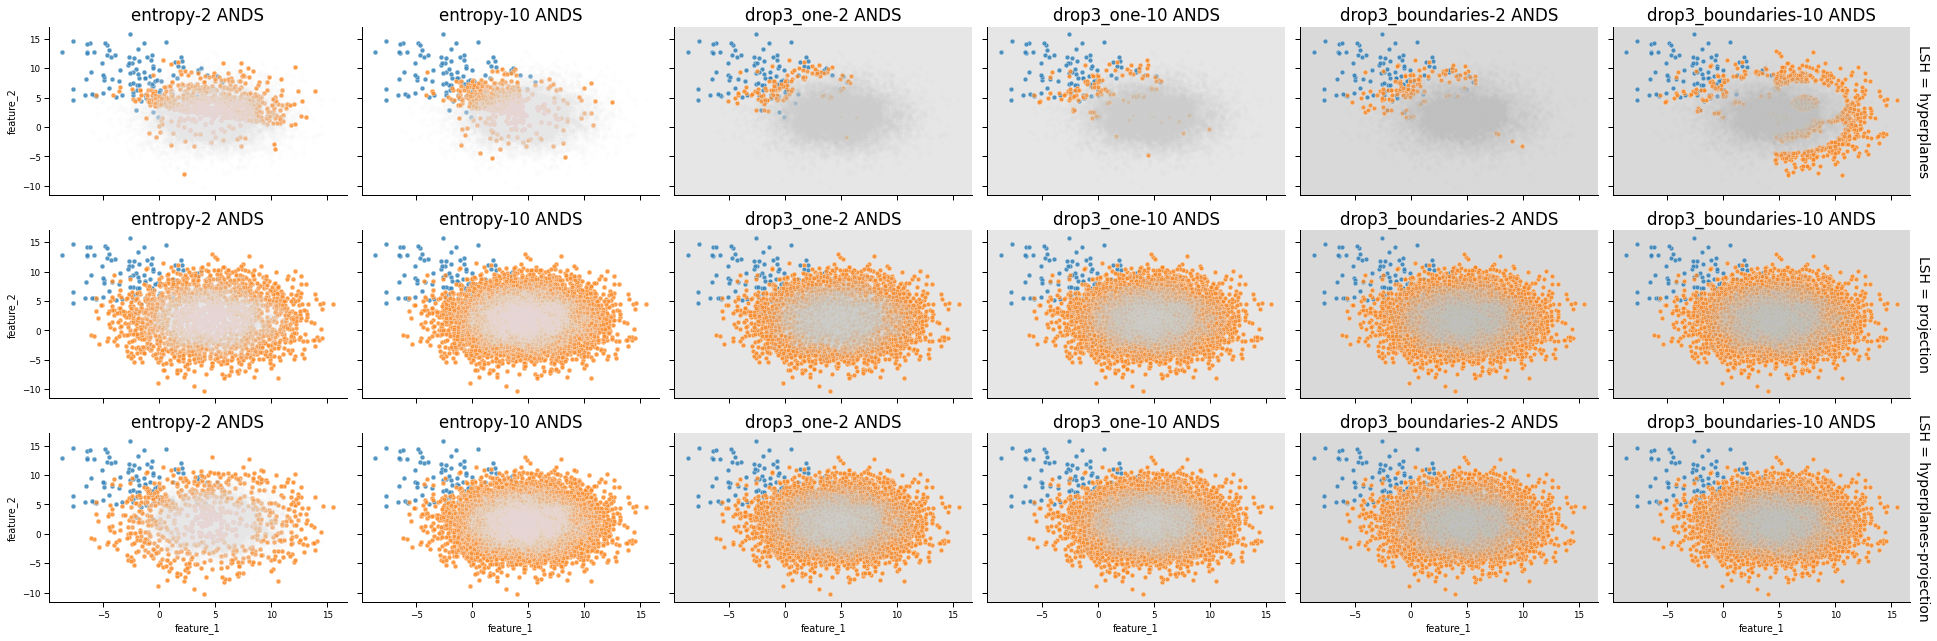

In [32]:
plot_example(ds[3])